In [2]:
!pip install torch torchvision
!pip install lion-pytorch

import os
import math
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from itertools import cycle
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    confusion_matrix, matthews_corrcoef, cohen_kappa_score,
    log_loss, roc_auc_score
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lion_pytorch import Lion

# **Dry Bean Dataset**
https://www.kaggle.com/datasets/muratkokludataset/dry-bean-dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Dry_Bean_Dataset.csv')

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

if 'Class' in df.columns:
    le_hat = LabelEncoder()
    df['Class'] = le_hat.fit_transform(df['Class'].astype(str))
    print("Hatype classes mapping:", dict(zip(le_hat.classes_, le_hat.transform(le_hat.classes_))))

df.to_csv('/content/drive/MyDrive/Dataset/Dry_Bean_Dataset_cleaned.csv', index=False)

print("Shape:", df.shape)

duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

df = df.drop_duplicates()
print(f"Shape after removing duplicates: {df.shape}")

# Show class distribution
print(df['Class'].value_counts())

Hatype classes mapping: {'BARBUNYA': np.int64(0), 'BOMBAY': np.int64(1), 'CALI': np.int64(2), 'DERMASON': np.int64(3), 'HOROZ': np.int64(4), 'SEKER': np.int64(5), 'SIRA': np.int64(6)}
Shape: (13611, 17)
Number of duplicate rows: 68
Shape after removing duplicates: (13543, 17)
Class
3    3546
6    2636
5    2027
4    1860
2    1630
0    1322
1     522
Name: count, dtype: int64


In [ ]:
class GLULayer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.1):
        super(GLULayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim * 2)
        self.bn = nn.BatchNorm1d(output_dim * 2)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x_proj = self.fc(x)
        x_proj = self.bn(x_proj)
        x1, x2 = x_proj.chunk(2, dim=-1)
        x_glu = x1 * torch.sigmoid(x2)
        x_glu = self.dropout(x_glu)
        return x_glu

class FeatureTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, n_glu_layers, shared_layers=None, dropout=0.1):
        super().__init__()
        self.shared = shared_layers
        self.blocks = nn.ModuleList()
        if input_dim != output_dim:
            self.initial_layer = GLULayer(input_dim, output_dim, dropout)
        else:
            self.initial_layer = None
        for i in range(n_glu_layers):
            self.blocks.append(GLULayer(output_dim, output_dim, dropout))
    def forward(self, x):
        if self.initial_layer is not None:
            x = self.initial_layer(x)
        if self.shared is not None and x.size(1) == self.shared[0].fc.out_features // 2:
            for layer in self.shared:
                residual = x
                x = layer(x)
                if residual.shape == x.shape:
                    x = (x + residual) * math.sqrt(0.5)
        for layer in self.blocks:
            residual = x
            x = layer(x)
            if residual.shape == x.shape:
                x = (x + residual) * math.sqrt(0.5)
        return x

class Sparsemax(nn.Module):
    def forward(self, input):
        input = input - input.max(dim=1, keepdim=True)[0]
        z_sorted, _ = torch.sort(input, dim=1, descending=True)
        k = torch.arange(1, input.size(1)+1, device=input.device).float()
        z_cumsum = torch.cumsum(z_sorted, dim=1)
        k_mask = 1 + k * z_sorted > z_cumsum
        k_max = torch.clamp(k_mask.sum(dim=1, keepdim=True), min=1)
        tau_sum = torch.gather(z_cumsum, 1, k_max.long() - 1)
        tau = (tau_sum - 1) / k_max
        output = torch.clamp(input - tau, min=0)
        return output

class AttentiveTransformer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AttentiveTransformer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.sparsemax = Sparsemax()
    def forward(self, x, prior):
        x = self.fc(x)
        x = self.bn(x)
        x = x * prior
        x = self.sparsemax(x)
        return x

class DecisionStep(nn.Module):
    def __init__(self, input_dim, feature_dim, output_dim, shared_layers=None, n_glu=2, gamma=1.3, dropout=0.1):
        super().__init__()
        self.gamma=gamma
        self.attentive_transformer = AttentiveTransformer(
            input_dim=feature_dim // 2,
            output_dim=input_dim
        )
        self.feature_transformer = FeatureTransformer(
            input_dim=input_dim,
            output_dim=feature_dim,
            n_glu_layers=n_glu,
            shared_layers=shared_layers,
            dropout=dropout
        )
        self.n_d = feature_dim // 2
        self.n_a = feature_dim - self.n_d
    def forward(self, a_prev, prior, x_o):
        mask = self.attentive_transformer(a_prev, prior)
        masked_x = x_o * mask
        ft_output = self.feature_transformer(masked_x)
        d_i = ft_output[:, :self.n_d]
        a_i = ft_output[:, self.n_d:]
        d_i = F.relu(d_i)
        prior_next = prior * (self.gamma - mask)
        return d_i, a_i, mask, prior_next

class CustomTabNetEncoder(nn.Module):
    def __init__(self, input_dim=16, feature_dim=96, n_steps=3, gamma=1.3,
                 n_glu=2, n_shared=2, n_independent=2, dropout=0.1):
        super().__init__()
        self.n_steps = n_steps
        self.gamma = gamma
        self.input_dim = input_dim
        self.feature_dim = feature_dim
        self.shared_layers = nn.ModuleList()
        for i in range(n_shared):
            self.shared_layers.append(GLULayer(feature_dim, feature_dim, dropout))
        self.initial_transform = FeatureTransformer(
            input_dim=input_dim,
            output_dim=feature_dim,
            n_glu_layers=n_shared + n_independent,
            shared_layers=None,
            dropout=dropout
        )
        self.decision_steps = nn.ModuleList([
            DecisionStep(
                input_dim=input_dim,
                feature_dim=feature_dim,
                output_dim=feature_dim,
                shared_layers=self.shared_layers,
                n_glu=n_glu,
                dropout=dropout
            )
            for _ in range(n_steps)
        ])
        for step in self.decision_steps:
            step.gamma = gamma
        self.bn = nn.BatchNorm1d(input_dim)
        self._initialize_weights()
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def forward(self, x):
        x_o = self.bn(x)
        prior = torch.ones_like(x_o)
        initial_output = self.initial_transform(x_o)
        n_d = self.feature_dim // 2
        d0 = initial_output[:, :n_d]
        a0 = initial_output[:, n_d:]
        decision_outputs = []
        a_prev = a0
        for step in self.decision_steps:
            d_i, a_i, mask, prior = step(a_prev, prior, x_o)
            decision_outputs.append(d_i)
            a_prev = a_i
        aggregated = torch.stack(decision_outputs, dim=0).sum(dim=0)

        return aggregated

class CustomTabNetClassifier(nn.Module):
    def __init__(self, input_dim=16, feature_dim=96, n_steps=3, gamma=1.3,
                 n_glu=2, n_shared=2, n_independent=2, num_classes=7, dropout=0.1):
        super(CustomTabNetClassifier, self).__init__()
        self.encoder = CustomTabNetEncoder(
            input_dim=input_dim,
            feature_dim=feature_dim,
            n_steps=n_steps,
            gamma=gamma,
            n_glu=n_glu,
            n_shared=n_shared,
            n_independent=n_independent,
            dropout=dropout
        )
        self.head = nn.Linear(feature_dim // 2, num_classes)
        self._initialize_weights()
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def forward(self, x):
        encoded = self.encoder(x)
        return self.head(encoded)

df = pd.read_csv('/content/drive/MyDrive/Dataset/Dry_Bean_Dataset_cleaned.csv')
X = df.drop(columns=["Class"])
y = df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=1/3, stratify=y_test, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, drop_last=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, drop_last=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X.shape[1]
print(f"Input dimension: {input_dim}")
model = CustomTabNetClassifier(
    input_dim=input_dim,
    feature_dim=96,
    n_steps=3,
    gamma=1.3,
    n_glu=2,
    n_shared=2,
    n_independent=2,
    num_classes=7,
    dropout=0.1
).to(device)

criterion = torch.nn.CrossEntropyLoss()
from lion_pytorch import Lion
optimizer = Lion(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    total_loss = 0
    sample_count = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            batch_size = X_batch.size(0)
            total_loss += loss.item() * batch_size
            sample_count += batch_size
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    model.train()
    return correct / total, total_loss / sample_count

def train(model, train_loader, val_loader, scheduler, epochs=100, patience=20):
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    best_val_acc = 0.0
    best_model_state = None
    epochs_without_improvement = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_acc = correct / total
        train_loss = total_loss / len(train_loader)
        val_acc, val_loss = evaluate(model, val_loader)
        scheduler.step(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1:02d}: "
              f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}, "
              f"LR = {optimizer.param_groups[0]['lr']:.6f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(" Early stopping triggered!")
                break
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f" Loaded best model with validation accuracy: {best_val_acc:.4f}")
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': best_val_acc,
        }, 'best_tabnet_model.pth')
        print(" Best model saved to 'best_tabnet_model.pth'")
    return history

history = train(model, train_loader, val_loader, scheduler, epochs=100, patience=20)
def evaluate_test(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

test_accuracy = evaluate_test(model, test_loader)
def get_all_preds(model, loader, device):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_prob)

start_infer = time.time()
y_test_true, y_test_pred, y_test_prob = get_all_preds(model, test_loader, device)
end_infer = time.time()
inference_time = (end_infer - start_infer) / len(y_test_true)
train_acc, train_loss = evaluate(model, train_loader)
val_acc, val_loss = evaluate(model, val_loader)
test_acc, test_loss = evaluate(model, test_loader)
precision = precision_score(y_test_true, y_test_pred, average='macro', zero_division=0)
recall = recall_score(y_test_true, y_test_pred, average='macro')
f1 = f1_score(y_test_true, y_test_pred, average='macro')
mcc = matthews_corrcoef(y_test_true, y_test_pred)
cohen_kappa = cohen_kappa_score(y_test_true, y_test_pred)
logloss = log_loss(y_test_true, y_test_prob)

print("\n=== Final Evaluation Metrics ===")
print(f"Training Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Matthews Corr Coef: {mcc:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa:.4f}")
print(f"Log Loss: {logloss:.4f}")

Input dimension: 16
Epoch 01: Train Loss = 0.6798, Train Acc = 0.7701, Val Loss = 0.3223, Val Acc = 0.8986, LR = 0.001000
Epoch 02: Train Loss = 0.3650, Train Acc = 0.8733, Val Loss = 0.2469, Val Acc = 0.9159, LR = 0.001000
Epoch 03: Train Loss = 0.3408, Train Acc = 0.8846, Val Loss = 0.2199, Val Acc = 0.9254, LR = 0.001000
Epoch 04: Train Loss = 0.2957, Train Acc = 0.8953, Val Loss = 0.2135, Val Acc = 0.9225, LR = 0.001000
Epoch 05: Train Loss = 0.2839, Train Acc = 0.8992, Val Loss = 0.2166, Val Acc = 0.9240, LR = 0.001000
Epoch 06: Train Loss = 0.2861, Train Acc = 0.8980, Val Loss = 0.2160, Val Acc = 0.9240, LR = 0.001000
Epoch 07: Train Loss = 0.2554, Train Acc = 0.9064, Val Loss = 0.2110, Val Acc = 0.9243, LR = 0.001000
Epoch 08: Train Loss = 0.2702, Train Acc = 0.9019, Val Loss = 0.2086, Val Acc = 0.9254, LR = 0.001000
Epoch 09: Train Loss = 0.2467, Train Acc = 0.9088, Val Loss = 0.2049, Val Acc = 0.9229, LR = 0.000500
Epoch 10: Train Loss = 0.2504, Train Acc = 0.9091, Val Loss = 


Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.94      0.89      0.91       132
      BOMBAY       1.00      1.00      1.00        52
        CALI       0.93      0.92      0.93       163
    DERMASON       0.91      0.91      0.91       355
       HOROZ       0.95      0.97      0.96       193
       SEKER       0.95      0.95      0.95       203
        SIRA       0.85      0.87      0.86       264

    accuracy                           0.92      1362
   macro avg       0.93      0.93      0.93      1362
weighted avg       0.92      0.92      0.92      1362



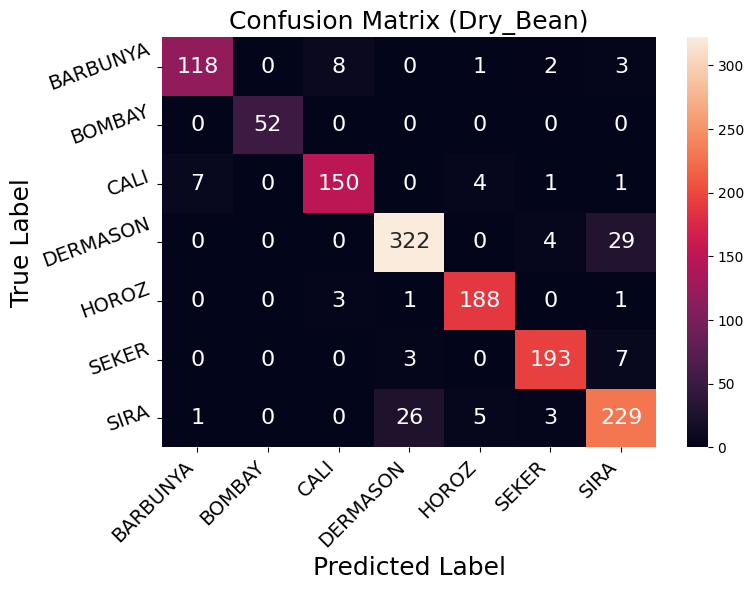

In [ ]:
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.numpy())
    return np.array(all_labels), np.array(all_preds)
y_true, y_pred = get_predictions(model, test_loader)
cm = confusion_matrix(y_true, y_pred)
class_names = [
    "BARBUNYA",
    "BOMBAY",
    "CALI",
    "DERMASON",
    "HOROZ",
    "SEKER",
    "SIRA",
]
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={'size': 16}
)

plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("True Label", fontsize=18)
plt.title("Confusion Matrix (Dry_Bean)", fontsize=18)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14, rotation=20)
plt.tight_layout()
plt.show()

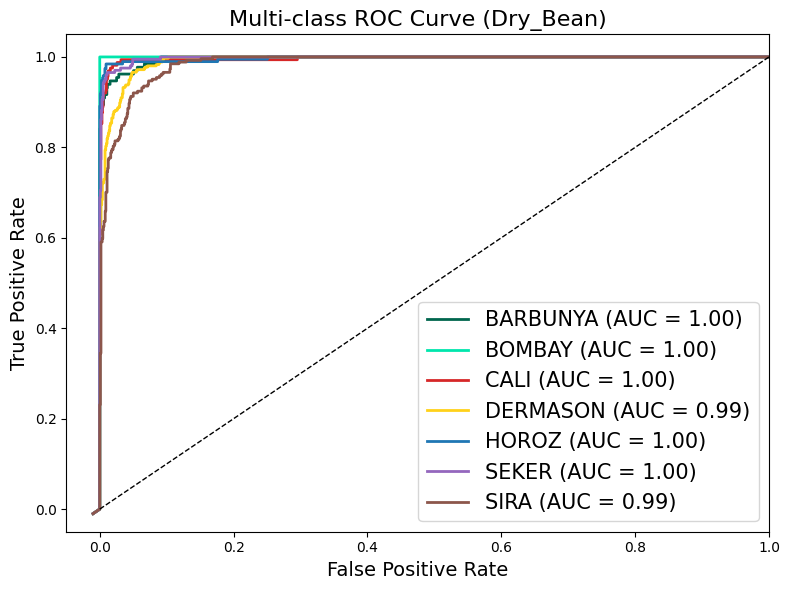

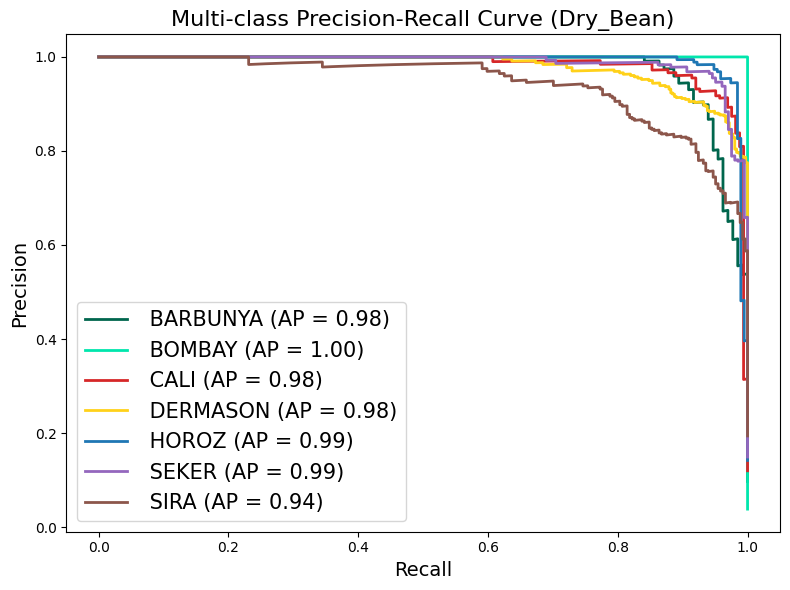

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from itertools import cycle
class_names = [
    "BARBUNYA",
    "BOMBAY",
    "CALI",
    "DERMASON",
    "HOROZ",
    "SEKER",
    "SIRA",
]
n_classes = len(class_names)

# Get probabilities for each class
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y_batch.numpy())

y_true = np.array(all_labels)
y_proba = np.array(all_probs)

# Binarize true labels for one-vs-rest ROC/PR curves
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(8, 6))
colors = cycle(['#00664d', '#00e6ac', '#d62728', '#ffd11a', '#1f77b4', '#9467bd', '#8c564b'])

for i, color in zip(range(n_classes), colors):
    fpr_i = np.insert(fpr[i], 0, -0.01)
    tpr_i = np.insert(tpr[i], 0, -0.01)
    plt.plot(fpr_i, tpr_i, color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:0.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curve (Dry_Bean)', fontsize=16)
plt.legend(loc="lower right", fontsize=15)
plt.grid(False)
plt.tight_layout()
plt.show()

precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], y_proba[:, i])

# Plot
plt.figure(figsize=(8, 6))
colors = cycle(['#00664d', '#00e6ac', '#d62728', '#ffd11a', '#1f77b4', '#9467bd', '#8c564b'])

for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f' {class_names[i]} (AP = {avg_precision[i]:0.2f})')

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Multi-class Precision-Recall Curve (Dry_Bean)', fontsize=16)
plt.legend(loc="lower left", fontsize=15)
plt.grid(False)
plt.tight_layout()
plt.show()


# **Treatment of Migraine Headaches (KosteckiDillon)**
https://www.kaggle.com/datasets/ukveteran/treatment-of-migraine-headaches

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/KosteckiDillon.csv')

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

if 'hatype' in df.columns:
    le_hat = LabelEncoder()
    df['hatype'] = le_hat.fit_transform(df['hatype'].astype(str))
    print("Hatype classes mapping:", dict(zip(le_hat.classes_, le_hat.transform(le_hat.classes_))))

if 'headache' in df.columns:
    df['headache'] = df['headache'].map({'yes': 1, 'no': 0})

if 'sex' in df.columns:
    df['sex'] = df['sex'].map({'female': 1, 'male': 0})

if 'medication' in df.columns:
    le_med = LabelEncoder()
    df['medication'] = le_med.fit_transform(df['medication'].astype(str))
    print("Medication classes mapping:", dict(zip(le_med.classes_, le_med.transform(le_med.classes_))))

df.to_csv('/content/drive/MyDrive/Dataset/KosteckiDillon_cleaned.csv', index=False)

print("Shape:", df.shape)

duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

print("\nClass distribution (encoded hatype):")
print(df['hatype'].value_counts())

Hatype classes mapping: {'Aura': np.int64(0), 'Mixed': np.int64(1), 'No Aura': np.int64(2)}
Medication classes mapping: {'continuing': np.int64(0), 'none': np.int64(1), 'reduced': np.int64(2)}
Shape: (4152, 9)
Number of duplicate rows: 1

Class distribution (encoded hatype):
hatype
2    1985
0    1710
1     457
Name: count, dtype: int64


In [ ]:
class GLULayer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.1):
        super(GLULayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim * 2)
        self.bn = nn.BatchNorm1d(output_dim * 2)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x_proj = self.fc(x)
        x_proj = self.bn(x_proj)
        x1, x2 = x_proj.chunk(2, dim=-1)
        x_glu = x1 * torch.sigmoid(x2)
        x_glu = self.dropout(x_glu)
        return x_glu

class FeatureTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, n_glu_layers, shared_layers=None, dropout=0.1):
        super().__init__()
        self.shared = shared_layers
        self.blocks = nn.ModuleList()
        if input_dim != output_dim:
            self.initial_layer = GLULayer(input_dim, output_dim, dropout)
        else:
            self.initial_layer = None
        for i in range(n_glu_layers):
            self.blocks.append(GLULayer(output_dim, output_dim, dropout))
    def forward(self, x):
        if self.initial_layer is not None:
            x = self.initial_layer(x)
        if self.shared is not None and x.size(1) == self.shared[0].fc.out_features // 2:
            for layer in self.shared:
                residual = x
                x = layer(x)
                if residual.shape == x.shape:
                    x = (x + residual) * math.sqrt(0.5)
        for layer in self.blocks:
            residual = x
            x = layer(x)
            if residual.shape == x.shape:
                x = (x + residual) * math.sqrt(0.5)
        return x

class Sparsemax(nn.Module):
    def forward(self, input):
        input = input - input.max(dim=1, keepdim=True)[0]
        z_sorted, _ = torch.sort(input, dim=1, descending=True)
        k = torch.arange(1, input.size(1)+1, device=input.device).float()
        z_cumsum = torch.cumsum(z_sorted, dim=1)
        k_mask = 1 + k * z_sorted > z_cumsum
        k_max = torch.clamp(k_mask.sum(dim=1, keepdim=True), min=1)
        tau_sum = torch.gather(z_cumsum, 1, k_max.long() - 1)
        tau = (tau_sum - 1) / k_max
        output = torch.clamp(input - tau, min=0)
        return output

class AttentiveTransformer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AttentiveTransformer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.sparsemax = Sparsemax()
    def forward(self, x, prior):
        x = self.fc(x)
        x = self.bn(x)
        x = x * prior
        x = self.sparsemax(x)
        return x

class DecisionStep(nn.Module):
    def __init__(self, input_dim, feature_dim, output_dim, shared_layers=None, n_glu=2, gamma=1.3, dropout=0.1):
        super().__init__()
        self.gamma=gamma
        self.attentive_transformer = AttentiveTransformer(
            input_dim=feature_dim // 2,
            output_dim=input_dim
        )
        self.feature_transformer = FeatureTransformer(
            input_dim=input_dim,
            output_dim=feature_dim,
            n_glu_layers=n_glu,
            shared_layers=shared_layers,
            dropout=dropout
        )
        self.n_d = feature_dim // 2
        self.n_a = feature_dim - self.n_d
    def forward(self, a_prev, prior, x_o):
        mask = self.attentive_transformer(a_prev, prior)
        masked_x = x_o * mask
        ft_output = self.feature_transformer(masked_x)
        d_i = ft_output[:, :self.n_d]
        a_i = ft_output[:, self.n_d:]
        d_i = F.relu(d_i)
        prior_next = prior * (self.gamma - mask)
        return d_i, a_i, mask, prior_next

class CustomTabNetEncoder(nn.Module):
    def __init__(self, input_dim=8, feature_dim=96, n_steps=3, gamma=1.3,
                 n_glu=2, n_shared=2, n_independent=2, dropout=0.1):
        super().__init__()
        self.n_steps = n_steps
        self.gamma = gamma
        self.input_dim = input_dim
        self.feature_dim = feature_dim
        self.shared_layers = nn.ModuleList()
        for i in range(n_shared):
            self.shared_layers.append(GLULayer(feature_dim, feature_dim, dropout))
        self.initial_transform = FeatureTransformer(
            input_dim=input_dim,
            output_dim=feature_dim,
            n_glu_layers=n_shared + n_independent,
            shared_layers=None,
            dropout=dropout
        )
        self.decision_steps = nn.ModuleList([
            DecisionStep(
                input_dim=input_dim,
                feature_dim=feature_dim,
                output_dim=feature_dim,
                shared_layers=self.shared_layers,
                n_glu=n_glu,
                dropout=dropout
            )
            for _ in range(n_steps)
        ])
        for step in self.decision_steps:
            step.gamma = gamma
        self.bn = nn.BatchNorm1d(input_dim)
        self._initialize_weights()
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def forward(self, x):
        x_o = self.bn(x)
        prior = torch.ones_like(x_o)
        initial_output = self.initial_transform(x_o)
        n_d = self.feature_dim // 2
        d0 = initial_output[:, :n_d]
        a0 = initial_output[:, n_d:]
        decision_outputs = []
        a_prev = a0
        for step in self.decision_steps:
            d_i, a_i, mask, prior = step(a_prev, prior, x_o)
            decision_outputs.append(d_i)
            a_prev = a_i
        aggregated = torch.stack(decision_outputs, dim=0).sum(dim=0)

        return aggregated

class CustomTabNetClassifier(nn.Module):
    def __init__(self, input_dim=8, feature_dim=96, n_steps=3, gamma=1.3,
                 n_glu=2, n_shared=2, n_independent=2, num_classes=3, dropout=0.1):
        super(CustomTabNetClassifier, self).__init__()
        self.encoder = CustomTabNetEncoder(
            input_dim=input_dim,
            feature_dim=feature_dim,
            n_steps=n_steps,
            gamma=gamma,
            n_glu=n_glu,
            n_shared=n_shared,
            n_independent=n_independent,
            dropout=dropout
        )
        self.head = nn.Linear(feature_dim // 2, num_classes)
        self._initialize_weights()
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def forward(self, x):
        encoded = self.encoder(x)
        return self.head(encoded)

df = pd.read_csv('/content/drive/MyDrive/Dataset/KosteckiDillon_cleaned.csv')
X = df.drop(columns=["hatype"])
y = df["hatype"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=1/3, stratify=y_test, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, drop_last=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, drop_last=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X.shape[1]
print(f"Input dimension: {input_dim}")
model = CustomTabNetClassifier(
    input_dim=input_dim,
    feature_dim=96,
    n_steps=3,
    gamma=1.3,
    n_glu=2,
    n_shared=2,
    n_independent=2,
    num_classes=3,
    dropout=0.1
).to(device)

criterion = torch.nn.CrossEntropyLoss()
from lion_pytorch import Lion
optimizer = Lion(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    total_loss = 0
    sample_count = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            batch_size = X_batch.size(0)
            total_loss += loss.item() * batch_size
            sample_count += batch_size
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    model.train()
    return correct / total, total_loss / sample_count

def train(model, train_loader, val_loader, scheduler, epochs=100, patience=20):
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    best_val_acc = 0.0
    best_model_state = None
    epochs_without_improvement = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_acc = correct / total
        train_loss = total_loss / len(train_loader)
        val_acc, val_loss = evaluate(model, val_loader)
        scheduler.step(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1:02d}: "
              f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}, "
              f"LR = {optimizer.param_groups[0]['lr']:.6f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(" Early stopping triggered!")
                break
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f" Loaded best model with validation accuracy: {best_val_acc:.4f}")
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': best_val_acc,
        }, 'best_tabnet_model.pth')
        print(" Best model saved to 'best_tabnet_model.pth'")
    return history

history = train(model, train_loader, val_loader, scheduler, epochs=100, patience=20)
def evaluate_test(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

test_accuracy = evaluate_test(model, test_loader)

def get_all_preds(model, loader, device):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_prob)

start_infer = time.time()
y_test_true, y_test_pred, y_test_prob = get_all_preds(model, test_loader, device)
end_infer = time.time()
inference_time = (end_infer - start_infer) / len(y_test_true)
train_acc, train_loss = evaluate(model, train_loader)
val_acc, val_loss = evaluate(model, val_loader)
test_acc, test_loss = evaluate(model, test_loader)

precision = precision_score(y_test_true, y_test_pred, average='macro', zero_division=0)
recall = recall_score(y_test_true, y_test_pred, average='macro')
f1 = f1_score(y_test_true, y_test_pred, average='macro')
mcc = matthews_corrcoef(y_test_true, y_test_pred)
cohen_kappa = cohen_kappa_score(y_test_true, y_test_pred)
logloss = log_loss(y_test_true, y_test_prob)

print("\n=== Final Evaluation Metrics ===")
print(f"Training Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Matthews Corr Coef: {mcc:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa:.4f}")
print(f"Log Loss: {logloss:.4f}")

Input dimension: 8
Epoch 01: Train Loss = 0.9748, Train Acc = 0.5219, Val Loss = 0.7809, Val Acc = 0.6313, LR = 0.001000
Epoch 02: Train Loss = 0.7927, Train Acc = 0.6253, Val Loss = 0.8228, Val Acc = 0.6108, LR = 0.001000
Epoch 03: Train Loss = 0.7567, Train Acc = 0.6281, Val Loss = 0.7696, Val Acc = 0.6229, LR = 0.001000
Epoch 04: Train Loss = 0.6996, Train Acc = 0.6483, Val Loss = 0.7289, Val Acc = 0.6602, LR = 0.001000
Epoch 05: Train Loss = 0.6877, Train Acc = 0.6573, Val Loss = 0.7048, Val Acc = 0.6735, LR = 0.001000
Epoch 06: Train Loss = 0.6573, Train Acc = 0.6819, Val Loss = 0.6568, Val Acc = 0.7048, LR = 0.001000
Epoch 07: Train Loss = 0.6333, Train Acc = 0.7101, Val Loss = 0.6761, Val Acc = 0.7108, LR = 0.001000
Epoch 08: Train Loss = 0.6253, Train Acc = 0.6962, Val Loss = 0.6623, Val Acc = 0.6928, LR = 0.001000
Epoch 09: Train Loss = 0.5930, Train Acc = 0.7125, Val Loss = 0.6229, Val Acc = 0.7036, LR = 0.001000
Epoch 10: Train Loss = 0.5971, Train Acc = 0.7094, Val Loss = 0


Classification Report:
              precision    recall  f1-score   support

        Aura       0.96      0.91      0.93       171
       Mixed       0.98      1.00      0.99        46
     No Aura       0.93      0.96      0.94       199

    accuracy                           0.94       416
   macro avg       0.95      0.96      0.96       416
weighted avg       0.95      0.94      0.94       416



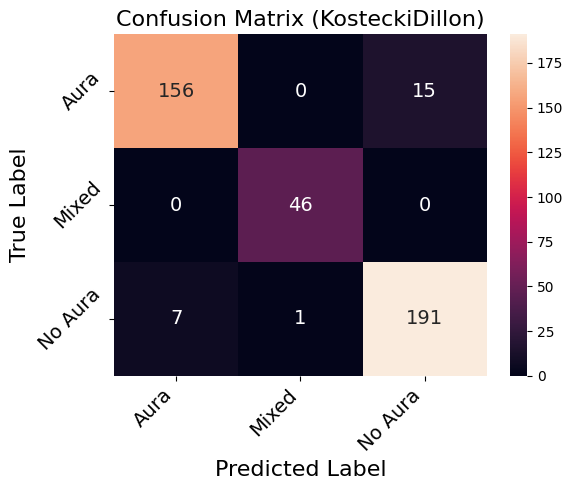

In [ ]:
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.numpy())
    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = get_predictions(model, test_loader)
cm = confusion_matrix(y_true, y_pred)
class_names = [
    "Aura",
    "Mixed",
    "No Aura",
]

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={'size': 14}
)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.title("Confusion Matrix (KosteckiDillon)", fontsize=16)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14, rotation=45)
plt.tight_layout()
plt.show()

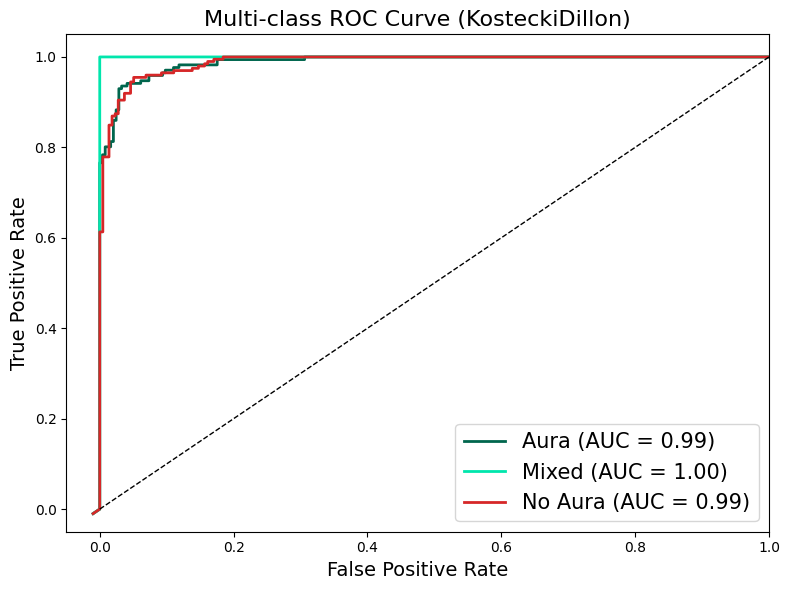

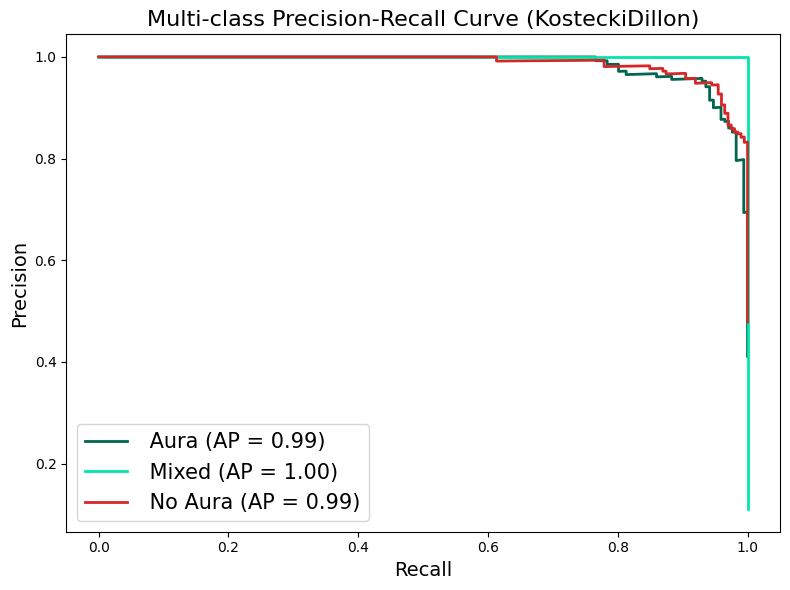

In [ ]:
class_names = [
    "Aura",
    "Mixed",
    "No Aura",
]
n_classes = len(class_names)

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y_batch.numpy())

y_true = np.array(all_labels)
y_proba = np.array(all_probs)

y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(8, 6))
colors = cycle(['#00664d', '#00e6ac', '#d62728'])

for i, color in zip(range(n_classes), colors):
    fpr_i = np.insert(fpr[i], 0, -0.01)
    tpr_i = np.insert(tpr[i], 0, -0.01)
    plt.plot(fpr_i, tpr_i, color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:0.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curve (KosteckiDillon)', fontsize=16)
plt.legend(loc="lower right", fontsize=15)
plt.grid(False)
plt.tight_layout()
plt.show()

precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], y_proba[:, i])

plt.figure(figsize=(8, 6))
colors = cycle(['#00664d', '#00e6ac', '#d62728', '#ffd11a'])

for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f' {class_names[i]} (AP = {avg_precision[i]:0.2f})')

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Multi-class Precision-Recall Curve (KosteckiDillon)', fontsize=16)
plt.legend(loc="lower left", fontsize=15)
plt.grid(False)
plt.tight_layout()
plt.show()

# **Sleep Health and Lifestyle Dataset**
https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/processed_sleep.csv')

print("Shape:", df.shape)

duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Shape: (374, 23)
Number of duplicate rows: 242


In [ ]:
class GLULayer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.1):
        super(GLULayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim * 2)
        self.bn = nn.BatchNorm1d(output_dim * 2)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x_proj = self.fc(x)
        x_proj = self.bn(x_proj)
        x1, x2 = x_proj.chunk(2, dim=-1)
        x_glu = x1 * torch.sigmoid(x2)
        x_glu = self.dropout(x_glu)
        return x_glu

class FeatureTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, n_glu_layers, shared_layers=None, dropout=0.1):
        super().__init__()
        self.shared = shared_layers
        self.blocks = nn.ModuleList()
        if input_dim != output_dim:
            self.initial_layer = GLULayer(input_dim, output_dim, dropout)
        else:
            self.initial_layer = None
        for i in range(n_glu_layers):
            self.blocks.append(GLULayer(output_dim, output_dim, dropout))
    def forward(self, x):
        if self.initial_layer is not None:
            x = self.initial_layer(x)
        if self.shared is not None and x.size(1) == self.shared[0].fc.out_features // 2:
            for layer in self.shared:
                residual = x
                x = layer(x)
                if residual.shape == x.shape:
                    x = (x + residual) * math.sqrt(0.5)
        for layer in self.blocks:
            residual = x
            x = layer(x)
            if residual.shape == x.shape:
                x = (x + residual) * math.sqrt(0.5)
        return x

class Sparsemax(nn.Module):
    def forward(self, input):
        input = input - input.max(dim=1, keepdim=True)[0]
        z_sorted, _ = torch.sort(input, dim=1, descending=True)
        k = torch.arange(1, input.size(1)+1, device=input.device).float()
        z_cumsum = torch.cumsum(z_sorted, dim=1)
        k_mask = 1 + k * z_sorted > z_cumsum
        k_max = torch.clamp(k_mask.sum(dim=1, keepdim=True), min=1)
        tau_sum = torch.gather(z_cumsum, 1, k_max.long() - 1)
        tau = (tau_sum - 1) / k_max
        output = torch.clamp(input - tau, min=0)
        return output

class AttentiveTransformer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AttentiveTransformer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.sparsemax = Sparsemax()
    def forward(self, x, prior):
        x = self.fc(x)
        x = self.bn(x)
        x = x * prior
        x = self.sparsemax(x)
        return x

class DecisionStep(nn.Module):
    def __init__(self, input_dim, feature_dim, output_dim, shared_layers=None, n_glu=2, gamma=1.3, dropout=0.1):
        super().__init__()
        self.gamma=gamma
        self.attentive_transformer = AttentiveTransformer(
            input_dim=feature_dim // 2,
            output_dim=input_dim
        )
        self.feature_transformer = FeatureTransformer(
            input_dim=input_dim,
            output_dim=feature_dim,
            n_glu_layers=n_glu,
            shared_layers=shared_layers,
            dropout=dropout
        )
        self.n_d = feature_dim // 2
        self.n_a = feature_dim - self.n_d
    def forward(self, a_prev, prior, x_o):
        mask = self.attentive_transformer(a_prev, prior)
        masked_x = x_o * mask
        ft_output = self.feature_transformer(masked_x)
        d_i = ft_output[:, :self.n_d]
        a_i = ft_output[:, self.n_d:]
        d_i = F.relu(d_i)
        prior_next = prior * (self.gamma - mask)
        return d_i, a_i, mask, prior_next

class CustomTabNetEncoder(nn.Module):
    def __init__(self, input_dim=22, feature_dim=96, n_steps=3, gamma=1.3,
                 n_glu=2, n_shared=2, n_independent=2, dropout=0.1):
        super().__init__()
        self.n_steps = n_steps
        self.gamma = gamma
        self.input_dim = input_dim
        self.feature_dim = feature_dim
        self.shared_layers = nn.ModuleList()
        for i in range(n_shared):
            self.shared_layers.append(GLULayer(feature_dim, feature_dim, dropout))
        self.initial_transform = FeatureTransformer(
            input_dim=input_dim,
            output_dim=feature_dim,
            n_glu_layers=n_shared + n_independent,
            shared_layers=None,
            dropout=dropout
        )
        self.decision_steps = nn.ModuleList([
            DecisionStep(
                input_dim=input_dim,
                feature_dim=feature_dim,
                output_dim=feature_dim,
                shared_layers=self.shared_layers,
                n_glu=n_glu,
                dropout=dropout
            )
            for _ in range(n_steps)
        ])
        for step in self.decision_steps:
            step.gamma = gamma
        self.bn = nn.BatchNorm1d(input_dim)
        self._initialize_weights()
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def forward(self, x):
        x_o = self.bn(x)
        prior = torch.ones_like(x_o)
        initial_output = self.initial_transform(x_o)
        n_d = self.feature_dim // 2
        d0 = initial_output[:, :n_d]
        a0 = initial_output[:, n_d:]
        decision_outputs = []
        a_prev = a0
        for step in self.decision_steps:
            d_i, a_i, mask, prior = step(a_prev, prior, x_o)
            decision_outputs.append(d_i)
            a_prev = a_i
        aggregated = torch.stack(decision_outputs, dim=0).sum(dim=0)

        return aggregated

class CustomTabNetClassifier(nn.Module):
    def __init__(self, input_dim=22, feature_dim=96, n_steps=3, gamma=1.3,
                 n_glu=2, n_shared=2, n_independent=2, num_classes=3, dropout=0.1):
        super(CustomTabNetClassifier, self).__init__()
        self.encoder = CustomTabNetEncoder(
            input_dim=input_dim,
            feature_dim=feature_dim,
            n_steps=n_steps,
            gamma=gamma,
            n_glu=n_glu,
            n_shared=n_shared,
            n_independent=n_independent,
            dropout=dropout
        )
        self.head = nn.Linear(feature_dim // 2, num_classes)
        self._initialize_weights()
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def forward(self, x):
        encoded = self.encoder(x)
        return self.head(encoded)

df = pd.read_csv('/content/drive/MyDrive/Dataset/processed_sleep.csv')
X = df.drop(columns=["Sleep_Disorder_Label"])
y = df["Sleep_Disorder_Label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=1/3, stratify=y_test, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, drop_last=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, drop_last=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X.shape[1]
print(f"Input dimension: {input_dim}")
model = CustomTabNetClassifier(
    input_dim=input_dim,
    feature_dim=96,
    n_steps=3,
    gamma=1.3,
    n_glu=2,
    n_shared=2,
    n_independent=2,
    num_classes=3,
    dropout=0.1
).to(device)

criterion = torch.nn.CrossEntropyLoss()
from lion_pytorch import Lion
optimizer = Lion(model.parameters(), lr=1e-3, weight_decay=1e-3)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    total_loss = 0
    sample_count = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            batch_size = X_batch.size(0)
            total_loss += loss.item() * batch_size
            sample_count += batch_size
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    model.train()
    return correct / total, total_loss / sample_count

def train(model, train_loader, val_loader, scheduler, epochs=100, patience=20):
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    best_val_acc = 0.0
    best_model_state = None
    epochs_without_improvement = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_acc = correct / total
        train_loss = total_loss / len(train_loader)
        val_acc, val_loss = evaluate(model, val_loader)
        scheduler.step(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1:02d}: "
              f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}, "
              f"LR = {optimizer.param_groups[0]['lr']:.6f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(" Early stopping triggered!")
                break
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f" Loaded best model with validation accuracy: {best_val_acc:.4f}")
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': best_val_acc,
        }, 'best_tabnet_model.pth')
        print(" Best model saved to 'best_tabnet_model.pth'")
    return history

history = train(model, train_loader, val_loader, scheduler, epochs=100, patience=20)

def evaluate_test(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

test_accuracy = evaluate_test(model, test_loader)

def get_all_preds(model, loader, device):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_prob)

start_infer = time.time()
y_test_true, y_test_pred, y_test_prob = get_all_preds(model, test_loader, device)
end_infer = time.time()
inference_time = (end_infer - start_infer) / len(y_test_true)
train_acc, train_loss = evaluate(model, train_loader)
val_acc, val_loss = evaluate(model, val_loader)
test_acc, test_loss = evaluate(model, test_loader)
precision = precision_score(y_test_true, y_test_pred, average='macro', zero_division=0)
recall = recall_score(y_test_true, y_test_pred, average='macro')
f1 = f1_score(y_test_true, y_test_pred, average='macro')
mcc = matthews_corrcoef(y_test_true, y_test_pred)
cohen_kappa = cohen_kappa_score(y_test_true, y_test_pred)
logloss = log_loss(y_test_true, y_test_prob)

print("\n=== Final Evaluation Metrics ===")
print(f"Training Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Matthews Corr Coef: {mcc:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa:.4f}")
print(f"Log Loss: {logloss:.4f}")

Input dimension: 22
Epoch 01: Train Loss = 1.1691, Train Acc = 0.4062, Val Loss = 1.0815, Val Acc = 0.5867, LR = 0.001000
Epoch 02: Train Loss = 0.9218, Train Acc = 0.6172, Val Loss = 1.0596, Val Acc = 0.5867, LR = 0.001000
Epoch 03: Train Loss = 0.7759, Train Acc = 0.7852, Val Loss = 1.0251, Val Acc = 0.5867, LR = 0.001000
Epoch 04: Train Loss = 0.5653, Train Acc = 0.8320, Val Loss = 0.9615, Val Acc = 0.5867, LR = 0.001000
Epoch 05: Train Loss = 0.4709, Train Acc = 0.8711, Val Loss = 0.8620, Val Acc = 0.7200, LR = 0.001000
Epoch 06: Train Loss = 0.4444, Train Acc = 0.8711, Val Loss = 0.7556, Val Acc = 0.7200, LR = 0.001000
Epoch 07: Train Loss = 0.4152, Train Acc = 0.8711, Val Loss = 0.6199, Val Acc = 0.7733, LR = 0.001000
Epoch 08: Train Loss = 0.4938, Train Acc = 0.8555, Val Loss = 0.5355, Val Acc = 0.8533, LR = 0.001000
Epoch 09: Train Loss = 0.3919, Train Acc = 0.8906, Val Loss = 0.5160, Val Acc = 0.8533, LR = 0.001000
Epoch 10: Train Loss = 0.4772, Train Acc = 0.8867, Val Loss = 


Classification Report:
              precision    recall  f1-score   support

        None       0.91      0.95      0.93        22
    Insomnia       0.89      1.00      0.94         8
 Sleep Apnea       1.00      0.75      0.86         8

    accuracy                           0.92        38
   macro avg       0.93      0.90      0.91        38
weighted avg       0.93      0.92      0.92        38



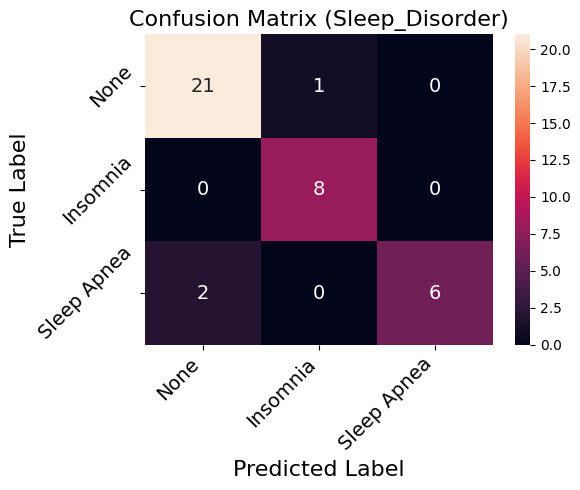

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.numpy())
    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = get_predictions(model, test_loader)
cm = confusion_matrix(y_true, y_pred)
class_names = [
    "None",
    "Insomnia",
    "Sleep Apnea"
]

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={'size': 14}
)

plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.title("Confusion Matrix (Sleep_Disorder)", fontsize=16)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14, rotation=45)
plt.tight_layout()
plt.show()